In [693]:
path = "../results/sst-5/llama/CAPO/hyper_default/benchmark_experiment_sst-5_llama_CAPO_44/98f1f86f932481b2c0dfca66f9296c78567235d5fef0bf067f0ec156c8ac261c/step_results_eval.csv"

In [694]:
import matplotlib.pyplot as plt
import pandas as pd

In [695]:
df = pd.read_csv(path)
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score
0,1,2025-03-14 23:24:56.468456,298.725282,0.521135,What sentiment does this movie review convey? ...,1437,453,685184,115459,0.596
1,1,2025-03-14 23:24:56.468456,298.725282,0.515944,Evaluate the emotional content of the followin...,1437,453,685184,115459,0.566
2,1,2025-03-14 23:24:56.468456,298.725282,0.507791,Examine the movie review and determine its sen...,1437,453,685184,115459,0.588
3,1,2025-03-14 23:24:56.468456,298.725282,0.504177,Read the movie review and identify its sentime...,1437,453,685184,115459,0.584
4,1,2025-03-14 23:24:56.468456,298.725282,0.503333,How would you describe the sentiment of this m...,1437,453,685184,115459,0.594
...,...,...,...,...,...,...,...,...,...,...
595,60,2025-03-15 00:37:06.979678,102.205586,0.549699,Analyze the emotional tone of the movie review...,2089,950,263477,36778,0.580
596,60,2025-03-15 00:37:06.979678,102.205586,0.545984,Analyze the emotional tone of the movie review...,2089,950,263477,36778,0.564
597,60,2025-03-15 00:37:06.979678,102.205586,0.545361,Examine the movie review and assess its emotio...,2089,950,263477,36778,0.578
598,60,2025-03-15 00:37:06.979678,102.205586,0.544950,Examine the emotional tone of the provided mov...,2089,950,263477,36778,0.570


In [696]:
df["total_tokens"] = (
    df["output_tokens_meta_llm"]
    + df["input_tokens_meta_llm"]
    + df["output_tokens_downstream_llm"]
    + df["input_tokens_downstream_llm"]
)
df["total_tokens"] = df["total_tokens"].cumsum()

In [697]:
# cum of tokens
df["output_tokens_downstream_llm_cum"] = df["output_tokens_downstream_llm"].cumsum()
df["output_tokens_meta_llm_cum"] = df["output_tokens_meta_llm"].cumsum()
df["input_tokens_downstream_llm_cum"] = df["input_tokens_downstream_llm"].cumsum()
df["input_tokens_meta_llm_cum"] = df["input_tokens_meta_llm"].cumsum()

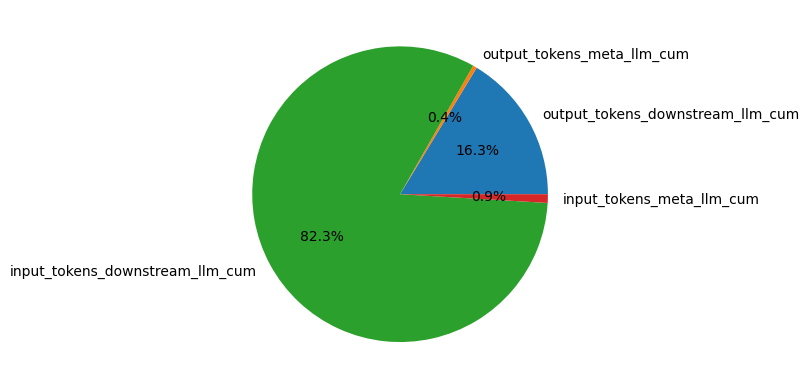

In [700]:
# plot pie
fig, ax = plt.subplots()
ax.pie(
    [
        df["output_tokens_downstream_llm_cum"].iloc[-1],
        df["output_tokens_meta_llm_cum"].iloc[-1],
        df["input_tokens_downstream_llm_cum"].iloc[-1],
        df["input_tokens_meta_llm_cum"].iloc[-1],
    ],
    labels=[
        "output_tokens_downstream_llm_cum",
        "output_tokens_meta_llm_cum",
        "input_tokens_downstream_llm_cum",
        "input_tokens_meta_llm_cum",
    ],
    autopct="%1.1f%%",
)
plt.show()

In [668]:
df["n_shots"] = df["prompt"].str.count("Input:") - 1

In [669]:
df["prompt_len"] = df["prompt"].str.len()

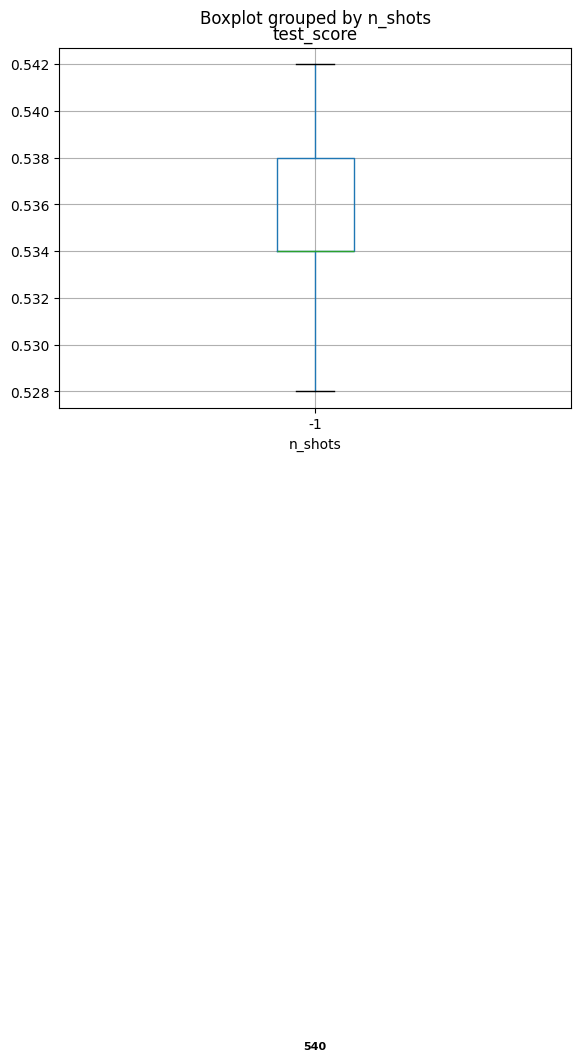

In [670]:
# correlation between number shots and score => boxplot, and give number of samples per n_shots
fig = df.boxplot(column="test_score", by="n_shots", showfliers=False)
# add number of samples per n_shots
num_samples = df.groupby("n_shots").size()
for i, n in enumerate(num_samples):
    fig.text(
        i + 1,
        0.5,
        n,
        ha="center",
        va="center",
        rotation=0,
        fontsize=8,
        color="black",
        fontweight="bold",
    )

plt.show();

In [671]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,total_tokens,n_shots,prompt_len,score_max
0,1,314.586934,0.492000,2645.0,938.0,389560.0,280367.0,0.4944,3704305.0,-1.0,208.0,0.513333
1,2,127.507449,0.496333,2700.0,979.0,199880.0,114252.0,0.4898,8483060.5,-1.0,211.1,0.513333
2,3,139.144626,0.499000,2680.0,945.0,189080.0,159177.0,0.4904,11848561.0,-1.0,207.9,0.513333
3,4,146.362601,0.504000,2614.0,879.0,183080.0,182972.0,0.5034,15464527.5,-1.0,200.4,0.513333
4,5,122.570207,0.505000,2608.0,901.0,192080.0,106862.0,0.5052,18790960.5,-1.0,203.4,0.513333
5,6,137.615569,0.511333,2641.0,945.0,192080.0,145287.0,0.5244,22027231.5,-1.0,196.5,0.526667
6,7,128.761047,0.522333,2595.0,890.0,186080.0,129758.0,0.5364,25317796.5,-1.0,189.6,0.530000
7,8,119.789524,0.526667,2566.0,866.0,183080.0,107834.0,0.5372,28373653.0,-1.0,179.8,0.530000
8,9,128.766694,0.529333,2560.0,850.0,180980.0,131322.0,0.5360,31434626.0,-1.0,179.7,0.536667
9,10,123.475559,0.530000,2560.0,850.0,180980.0,118658.0,0.5360,34522094.0,-1.0,179.7,0.536667


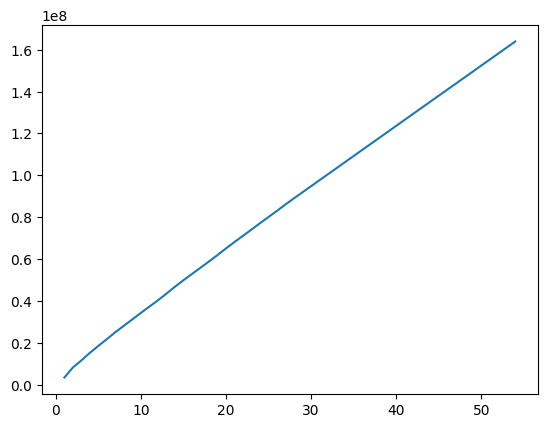

In [672]:
# plot step vs total tokens
plt.plot(df_grouped["step"], df_grouped["total_tokens"])

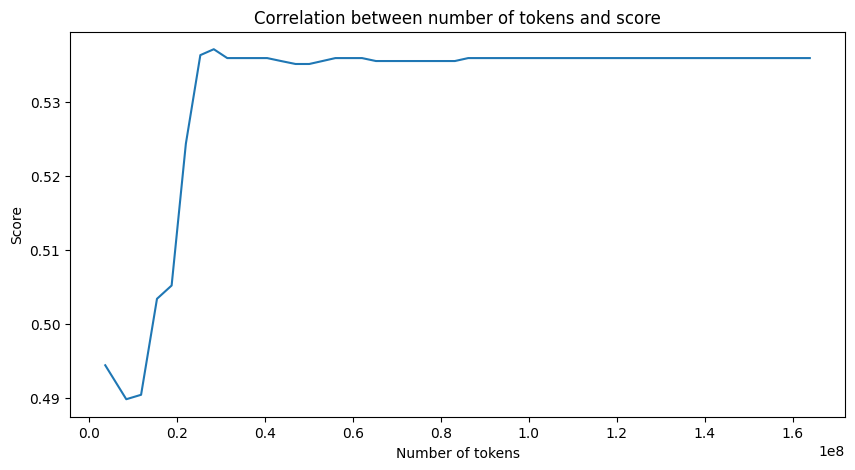

In [673]:
# plot score vs total tokens
plt.figure(figsize=(10, 5))
plt.title("Correlation between number of tokens and score")
plt.xlabel("Number of tokens")
plt.ylabel("Score")
plt.plot(df_grouped["total_tokens"], df_grouped["test_score"])
plt.show()

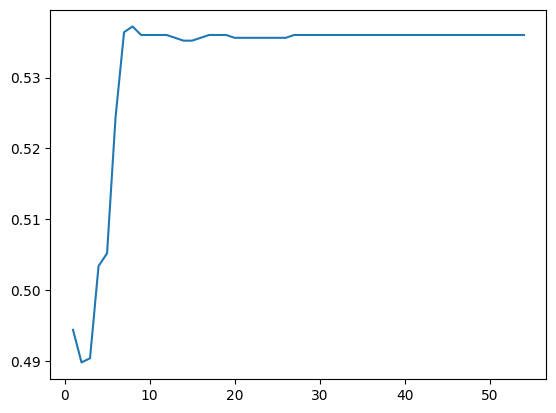

In [674]:
# plot token count vs step and adapt y-axis to min and max
column = "test_score"
plt.plot(df_grouped["step"], df_grouped[column])
plt.show();

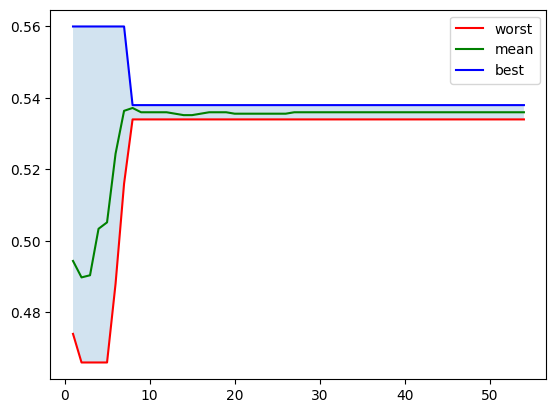

In [675]:
# x_axis => step, y_axis => worst_score, mean_score, best_score
col = "test_score"

worst_scores = df.groupby("step", as_index=False).min(numeric_only=True)[["step", col]]
mean_scores = df.groupby("step", as_index=False).mean(numeric_only=True)[["step", col]]
best_scores = df.groupby("step", as_index=False).max(numeric_only=True)[["step", col]]

plt.plot(worst_scores["step"], worst_scores[col], label="worst", color="red")
plt.plot(mean_scores["step"], mean_scores[col], label="mean", color="green")
plt.plot(best_scores["step"], best_scores[col], label="best", color="blue")
# fill area between lines
plt.fill_between(mean_scores["step"], worst_scores[col], best_scores[col], alpha=0.2)
plt.legend()
plt.show();

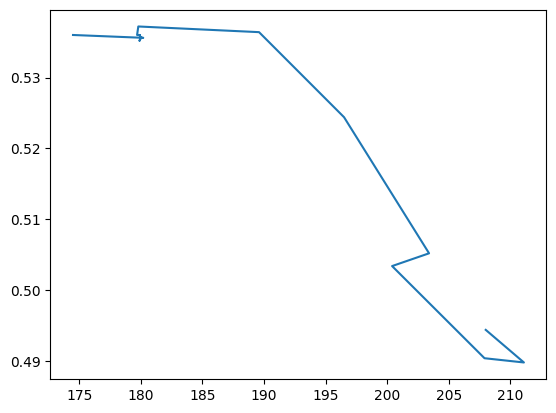

In [676]:
# plot score vs prompt length
plt.plot(df_grouped["prompt_len"], df_grouped["test_score"])
plt.show();

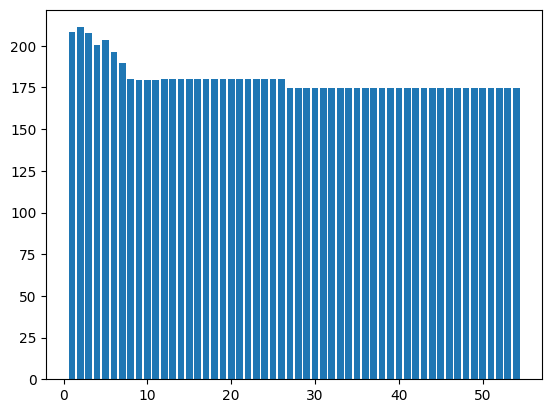

In [677]:
# prompt length vs step
plt.bar(df_grouped["step"], df_grouped["prompt_len"]);

### Analyze best prompts per step

In [678]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)
# df_best

C:\Users\tzehl\AppData\Local\Temp\ipykernel_3992\373190983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)


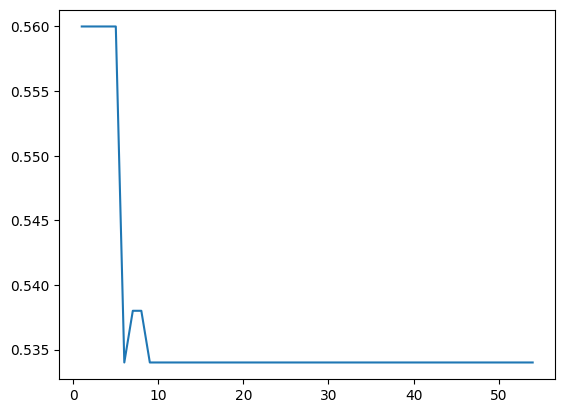

In [679]:
# max a line plot of the best score vs step
plt.plot(df_best["step"], df_best["test_score"]);

## Analyze Racing

In [680]:
from pprint import pprint as pp

p = lambda x: (pp(x.replace("\r", ""), compact=True, width=200))

In [681]:
df["test_score"].nlargest(10)

0     0.560
10    0.560
20    0.560
30    0.560
40    0.560
52    0.560
68    0.560
57    0.542
60    0.538
62    0.538
Name: test_score, dtype: float64

In [692]:
# best prompt
col = "test_score"
k_best = 9

best_prompt = df[df[col] == df[col].nlargest(k_best).values[k_best - 1]]
print("unique?", len(best_prompt["prompt"].unique()))
print("number of shots: ", best_prompt["n_shots"].values[0])
print("score: ", best_prompt[col].values[0])
print("first occurence: ", best_prompt["step"].values[0])
print("last occurence: ", best_prompt["step"].values[-1])
print("last train score: ", best_prompt["score"].values[-1].round(2))

p(best_prompt["prompt"].unique()[0])

unique? 2
number of shots:  -1
score:  0.538
first occurence:  7
last occurence:  54
last train score:  0.53
'Evaluate the sentiment of the movie review. Choose from: very negative, negative, neutral, positive, or very positive. Format your response with <final_answer> </final_answer>'


In [683]:
# load the prompt scores per block
path = path.replace("step_results_eval", "prompt_scores")

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

FileNotFoundError: [Errno 2] No such file or directory: '../results/sst-5/llama/EvoPromptGA/hyper/benchmark_experiment_sst-5_llama_EvoPromptGA_hyp/9f8cfb5ae20ad841d5068b4d0c197ef570e37bbc55f7e2077c8d4b8a6fbfd492/prompt_scores.csv'

In [ ]:
# get number of blocks per prompt by counting non nans per columns
n_blocks = df_blocks.count(axis=1) - 1

In [ ]:
n_blocks

0       4
1       5
2       1
3       8
4       2
       ..
242    10
243    10
244     1
245    10
246    10
Length: 247, dtype: int64

In [ ]:
df_count = pd.DataFrame({"n_blocks": n_blocks.values, "prompt": df_blocks["Unnamed: 0"]})

In [ ]:
df_count["n_blocks"].value_counts()

n_blocks
1     79
10    67
3     27
2     22
5     14
7     12
8     10
4      8
9      6
6      2
Name: count, dtype: int64

In [ ]:
# join with df
df_count = df_count.join(df.set_index("prompt"), on="prompt", how="left", lsuffix="_rrr")

# bin by test_score
df_count["test_score_bin"] = pd.cut(df_count["test_score"], bins=5)

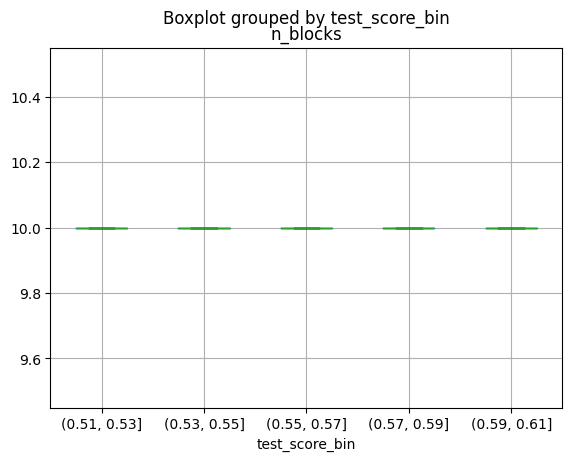

In [ ]:
# evals vs score => boxplot
df_count.boxplot(column="n_blocks", by="test_score_bin");

<Axes: ylabel='count'>

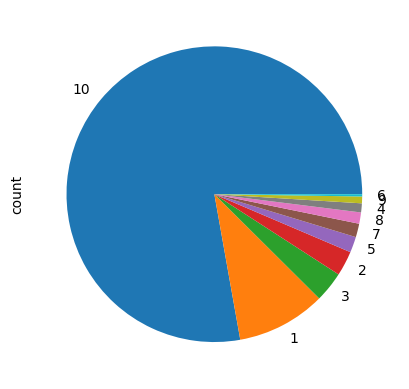

In [ ]:
# pie chart of number of blocks per prompt
df_count["n_blocks"].value_counts().plot.pie()

In [ ]:
df_count["n_blocks"].describe()

count    811.000000
mean       8.441430
std        3.139546
min        1.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: n_blocks, dtype: float64